# Runtime comparison of alignment/quantification methods

This notebook reviews how we ran other tools and obtained Figure 3 in our paper. Before clustering cells, we need to obtain a feature vector for each cell. Each cell should have a unique feature vector, and similar cells (or cells of the same type) should have similar feature vectors. Various methods have been used to obtain this feature vector; the two types of feature vectors we looked at consisted of: 

* gene/transcript abundances 
* TCCs of equivalence classes

Traditionally, cells have been represented using the abundances of different genes or transcripts. Tools such as eXpress quantify on aligned reads, a costly procedure done using tools such as Bowtie1 and HISAT. Therefore the runtimes of any procedure that quantifies on aligned reads are lower bounded by the alignment step. We look at the runtime of Bowtie and HISAT here.

We also look at the runtime of kallisto, which consists of pseudoaligning the reads followed by quantification of transcript abundances. Because TCCs does not require the second step, a pipeline that only requires pseudoalignment is even faster. 

Finally we look at how long the bash command "wc" takes to run on the input file. This is what we assume to be the fastest possible time to go through all reads in the file once.

In [2]:
# Modules used in this notebook 
import numpy as np
import os
import re
import colorsys
import matplotlib.pyplot as plt

The inputs to this pipeline are 

* path to modified kallisto

* path to reference mouse transcriptoime

* paths to the chromosomes of mouse genome (to be put without spaces in ./hisat_chr_path_list.txt)

In [2]:
modified_kallisto_path='/data/SS_RNA_seq/Code/kalliPso'
mouse_reference='/data/SS_RNA_seq/Zeisel/reference_transcriptome/Mus_musculus.GRCm38.rel79.cdna.all.fa'

seed=100

Run the script. This executes and times Bowtie, HISAT, kallisto quant (original kallisto), and kallisto pseudoalign (TCC or kallisto without quantification) for ten cells. The times are saved in the appropriate folders in this directory.

In [11]:
os.system('python time_test.py -k '+modified_kallisto_path+
              ' -r '+ mouse_reference+' -h ./hisat_chr_path_list.txt -s '+str(seed))

Load the times generated using the above script

In [4]:
with open('./TCC/time.time') as f: TCC=float(f.readline())
with open('./bowtie1/time.time') as f: bowtie1=float(f.readline())
with open('./hisat/time.time') as f: hisat=float(f.readline())
with open('./kallisto/time.time') as f: kallisto=float(f.readline())
with open('./wc/time.time') as f: wc=float(f.readline())

Generate the bar plot comparing the runtimes of different methods. 

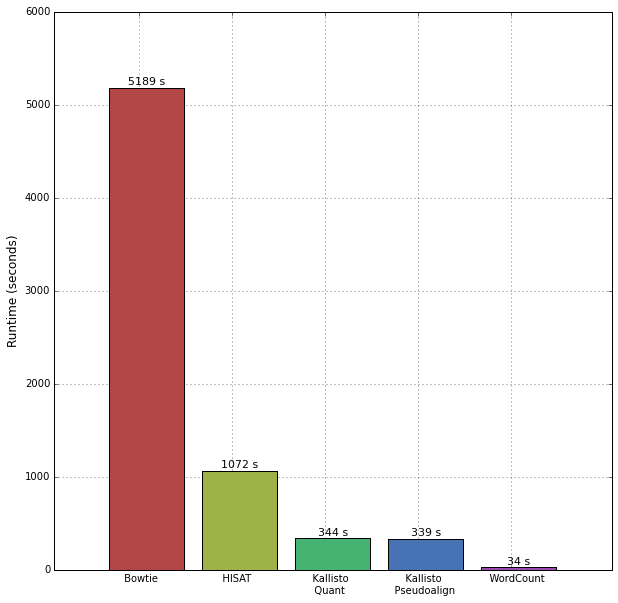

In [9]:
%matplotlib inline

# Generate RBG values to create a rainbow for N bars
N = 5
HSV_tuples = [(x*1.0/N, 0.6, 0.7) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)

menMeans = (bowtie1,hisat,kallisto,TCC,wc)

ind = np.arange(N)
width = 0.45

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, menMeans, width=0.8, color=RGB_tuples,zorder=4, align='center')
methods = [' Bowtie', '   HISAT','   Kallisto\n   Quant',
           '   Kallisto\n    Pseudoalign','    WordCount']
plt.grid()

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] -0.2 for patch in rects1]
plt.xticks(xticks_pos, methods, ha='center', rotation=0, size=10)

rects = ax.patches
hts=map(lambda x: str(int(x))+' s',menMeans)
for rect, ht in zip(rects, hts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, 
            ht, ha='center', va='bottom',fontsize=11)

plt.ylabel('Runtime (seconds)',size=12)
plt.show()

We can also look at the runtime of the clustering algorithms. The TCC vectors are an order of magnitude larger than the gene expression vectors, and we are interested in how much of a difference this makes.

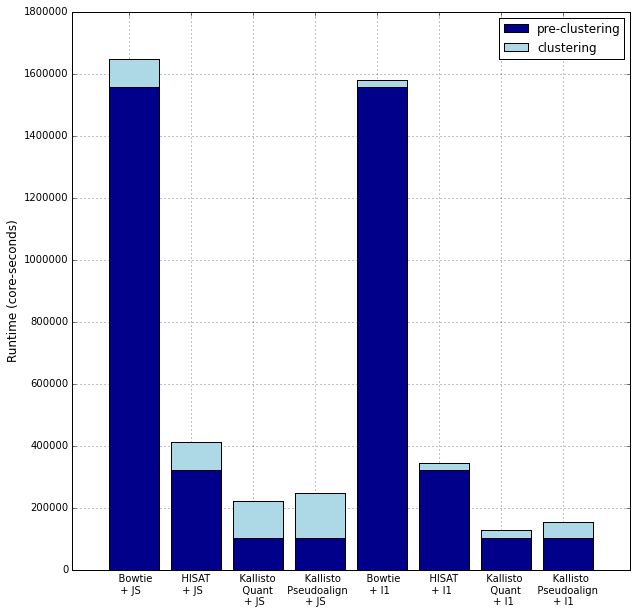

In [14]:
# Time clusterings
# os.system('bash time_pairwise_distances.sh')
file_list=['time_TCC.txt', 'time_kallisto.txt','time_UMI.txt','time_TCC_l1.txt',
           'time_kallisto_l1.txt','time_UMI_l1.txt']

# Sum the user and system run times outputted by the above bash script
times=np.zeros((6,1))
cur_time=0
for ind in range(6):
    with open ('../Zeisel_pipeline/'+file_list[ind]) as f:
        for line in f:
            line1=line.split()
            if len(line1)==2 and (line1[0]=='user' or line1[0]=='sys'):
                line2 = re.split("[ms]+", line1[1])
                cur_time += int(line2[0])*60 + float(line2[1])
    times[ind]=cur_time
    cur_time=0
    
# Plot
bottom_bar=np.array([300*bowtie1, 300*hisat, 300*kallisto, 300*TCC ,300*bowtie1, 300*hisat, 300*kallisto, 300*TCC ])
top_bar=np.array([times[2], times[2], times[1], times[0], times[5], times[5], times[4], times[3]])
total_ht=map(float,bottom_bar)+map(float,top_bar)
N=8
ind = np.arange(N)
width = 0.45
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, bottom_bar, width=0.8, color=
                'DarkBlue', zorder=4, align='center',label='pre-clustering')
rects2 = ax.bar(ind, top_bar, width=0.8, color=
                'LightBlue', zorder=4, align='center',label='clustering',bottom=bottom_bar)
methods = ['    Bowtie \n + JS', '   HISAT \n + JS','   Kallisto\n   Quant \n + JS',
           '     Kallisto\n Pseudoalign \n+ JS',
          '    Bowtie \n + l1', '   HISAT \n + l1','  Kallisto\n   Quant \n + l1',
          '     Kallisto\n   Pseudoalign \n+ l1']
plt.grid()
plt.legend()
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] -0.2 for patch in rects1]
plt.xticks(xticks_pos, methods, ha='center', rotation=0, size=10)
plt.ylabel('Runtime (core-seconds)',size=12)